# Import bibliotek

In [1]:
import os
import shutil
import librosa
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as ipd
from PIL import Image

Do zbudowania naszego zbioru danych wykorzystamy trzy zbiory:
*  KAUH
*  ICBHI
*  Covid-19

In [2]:
# ścieżki do katalogów z danymi
RAW_DATA_PATH = "./Raw_datasets/"
KAUH_DATA_PATH = f"./{RAW_DATA_PATH}/KAUH_Lung_files"
ICBHI_DATA_PATH = f"./{RAW_DATA_PATH}/Respiratory_Sound_Database"
COVID_19_DATA_PATH = f"./{RAW_DATA_PATH}/covid-19_dataset"

In [3]:
# Sprawdzanie poprawności ścieżek folderów
print("RAW DATA: ", os.path.exists(RAW_DATA_PATH))
print("KAUH: ", os.path.exists(KAUH_DATA_PATH))
print("ICBHI: ", os.path.exists(ICBHI_DATA_PATH))
print("COVID-19: ", os.path.exists(COVID_19_DATA_PATH))

RAW DATA:  True
KAUH:  True
ICBHI:  True
COVID-19:  True


# Przetwarzanie zbioru ICBHI

### Wczytanie danych o chorobach pacjentów

In [4]:
patient_diseases_info = pd.read_csv(f'./{ICBHI_DATA_PATH}/patient_diagnosis.csv')
patient_diseases_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   PatientID  126 non-null    int64 
 1   Diagnosis  126 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.1+ KB


In [5]:
unique_diseases_icbhi = patient_diseases_info['Diagnosis'].unique()
unique_diseases_icbhi = sorted(unique_diseases_icbhi)
print(f'Unikalne nazwy chorób płucnych: {unique_diseases_icbhi}')

Unikalne nazwy chorób płucnych: ['Asthma', 'Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'LRTI', 'Pneumonia', 'URTI']


                Ilość pacjentów:
Diagnosis                       
COPD                          64
Healthy                       26
URTI                          14
Bronchiectasis                 7
Bronchiolitis                  6
Pneumonia                      6
LRTI                           2
Asthma                         1


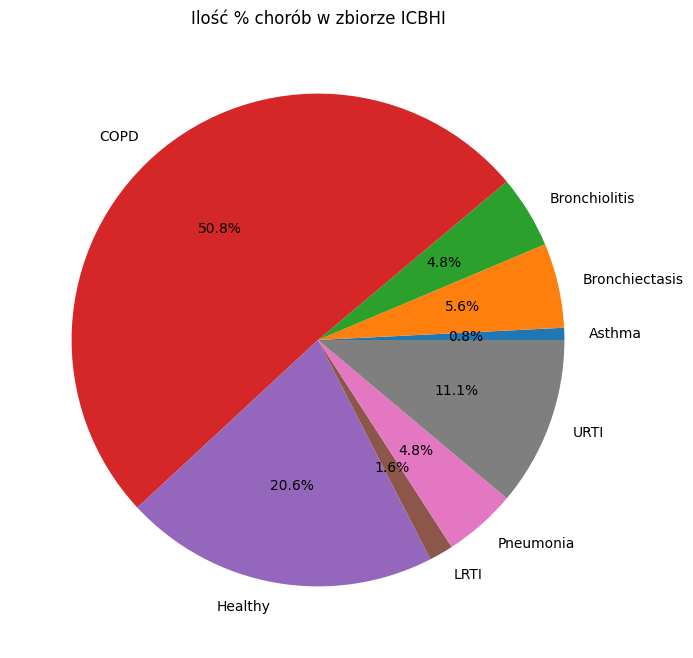

In [6]:
number_of_diseases = patient_diseases_info.groupby(['Diagnosis']).count()
print(number_of_diseases.sort_values(by=['PatientID'],ascending=False).rename(columns = {'PatientID':'Ilość pacjentów:'}))
plt.figure(figsize=(10,8))
plt.pie(number_of_diseases['PatientID'],labels=number_of_diseases.index,autopct='%1.1f%%')
plt.title("Ilość % chorób w zbiorze ICBHI")
plt.show()

### Segregacja plików audio ze względu na choroby 

In [7]:
#Tworzenie głównego folderu z danymi
if not os.path.exists('./data'):
    print("TWORZENIE KATALOGU GŁÓWNEGO")
    os.mkdir("./data")

#Tworzenie folderu dla audio
if not os.path.exists('./data/audio'):
    print("TWORZENIE KATALOGU DLA AUDIO")
    os.mkdir("./data/audio")

#Tworzenie podfolderów audio
for diseas in unique_diseases_icbhi:
    if not os.path.exists(f"./data/audio/{diseas}"):
        print(f"TWORZENIE PODKATALOGU DLA AUDIO CHOROB : {diseas}")
        os.mkdir(f"./data/audio/{diseas}")

In [8]:
#Segregacja plików audio ze względu na choroby
for diseas in unique_diseases_icbhi:
    print(f'CHOROBA {diseas}')

    #Szukanie po chorobie
    patient_list = patient_diseases_info[patient_diseases_info['Diagnosis'] == diseas]
    print(patient_list)
    
    for patient_id in patient_list['PatientID']:
        patient_files = glob.glob(f'{ICBHI_DATA_PATH}/audio_and_txt_files/{patient_id}*.wav')

        #print(f'Pliki pacjenta: {patient_files}')

        for patient_file in patient_files:
            print("KOPIOWANIE: ",patient_file)
            shutil.copy(patient_file, f'./data/audio/{diseas}')

print("Pliki zostały posegregowane...")

CHOROBA Asthma
   PatientID Diagnosis
2        103    Asthma
KOPIOWANIE:  ././Raw_datasets//Respiratory_Sound_Database/audio_and_txt_files\103_2b2_Ar_mc_LittC2SE.wav
CHOROBA Bronchiectasis
     PatientID       Diagnosis
10         111  Bronchiectasis
15         116  Bronchiectasis
67         168  Bronchiectasis
68         169  Bronchiectasis
95         196  Bronchiectasis
100        201  Bronchiectasis
114        215  Bronchiectasis
KOPIOWANIE:  ././Raw_datasets//Respiratory_Sound_Database/audio_and_txt_files\111_1b2_Tc_sc_Meditron.wav
KOPIOWANIE:  ././Raw_datasets//Respiratory_Sound_Database/audio_and_txt_files\111_1b3_Tc_sc_Meditron.wav
KOPIOWANIE:  ././Raw_datasets//Respiratory_Sound_Database/audio_and_txt_files\116_1b2_Pl_sc_Meditron.wav
KOPIOWANIE:  ././Raw_datasets//Respiratory_Sound_Database/audio_and_txt_files\116_1b2_Tc_sc_Meditron.wav
KOPIOWANIE:  ././Raw_datasets//Respiratory_Sound_Database/audio_and_txt_files\168_1b1_Al_sc_Meditron.wav
KOPIOWANIE:  ././Raw_datasets//Respira

In [9]:
#Tworzenie folderu dla spectogramów
if not os.path.exists('./data/spectograms'):
    print("TWORZENIE KATALOGU DLA SPEKTOGRAMÓW")
    os.mkdir("./data/spectograms")

#Tworzenie podfolderów spectogramów
for diseas in unique_diseases_icbhi:
    if not os.path.exists(f"./data/spectograms/{diseas}"):
        print(f"TWORZENIE PODKATALOGU DLA SPEKTOGRAMÓW CHOROBY : {diseas}")
        os.mkdir(f"./data/spectograms/{diseas}")

# Etapy tworzenia spektogramów dla pliku audio

In [10]:
audio_files = glob.glob('../lung_diseases_detection/data/audio/*/*.wav')
audio_files[1]

'../lung_diseases_detection/data/audio\\Asthma\\BP101_Asthma,E W,P L M,12,F.wav'

In [11]:
# Plik audio
ipd.Audio(audio_files[1])

In [12]:
# Wczytanie pliku
wave, sr = librosa.load(audio_files[1])

print(f'Wave: {wave[:10]}')
print(f'shape Wave: {wave.shape}')
print(f'SAMPLE RATE: {sr}')

Wave: [ 1.5422702e-06  2.1457672e-06  2.3096800e-06  1.9669533e-06
  1.0430813e-06 -3.9115548e-07 -1.8887222e-06 -2.9914081e-06
 -3.3266842e-06 -2.7045608e-06]
shape Wave: (298822,)
SAMPLE RATE: 22050


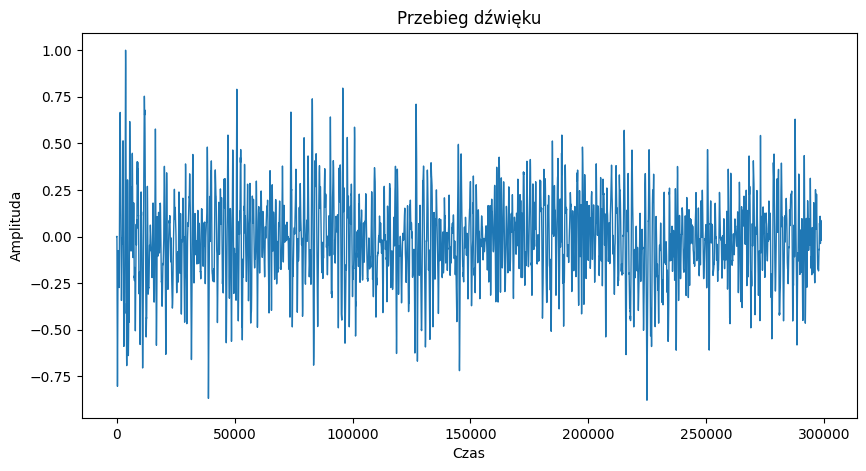

In [13]:
#Surowy przebieg pliku
pd.Series(wave).plot(figsize=(10, 5),
                  lw=1,
                  title='Przebieg dźwięku')
plt.ylabel('Amplituda')
plt.xlabel('Czas')
plt.show()

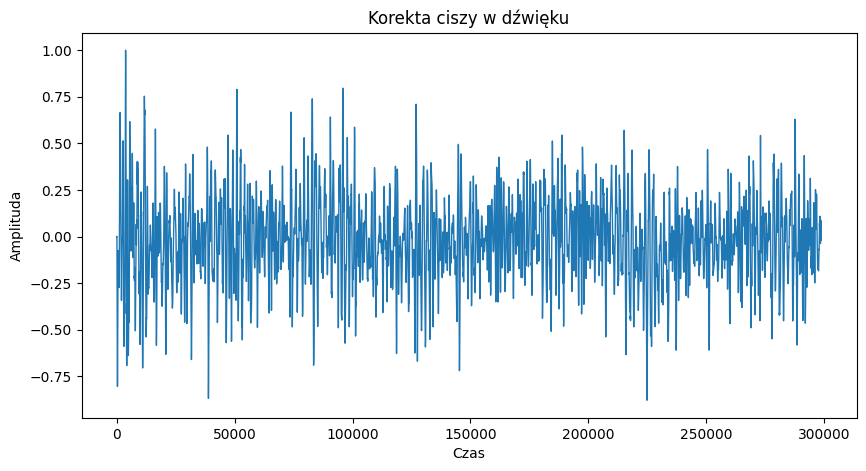

In [14]:
# Korekta ciszy dźwięku w audio
wave_trimmed, _ = librosa.effects.trim(wave, top_db=40)
pd.Series(wave_trimmed).plot(figsize=(10, 5),
                  lw=1,
                  title='Korekta ciszy w dźwięku')
plt.ylabel('Amplituda')
plt.xlabel('Czas')
plt.show()

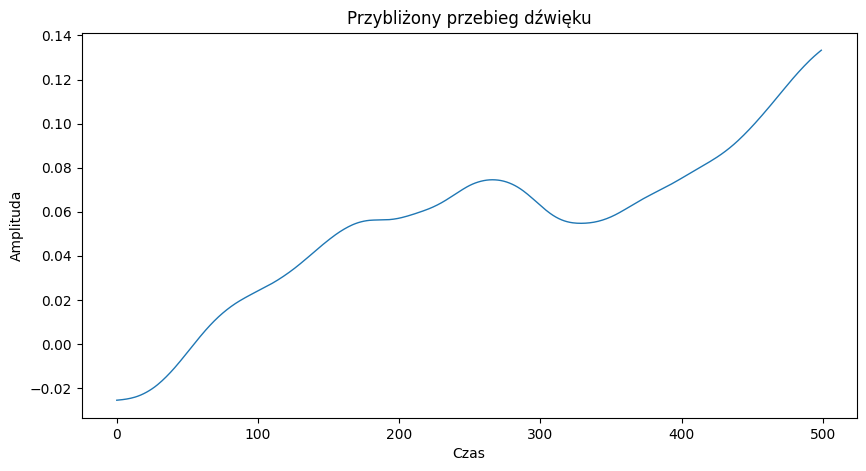

In [15]:
# Przybliżony przebieg dźwięku
pd.Series(wave[30000:30500]).plot(figsize=(10, 5),
                  lw=1,
                  title='Przybliżony przebieg dźwięku')
plt.ylabel('Amplituda')
plt.xlabel('Czas')
plt.show()

In [16]:
# Tranformata Fouriera
D = librosa.stft(wave)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
S_db.shape

(1025, 584)

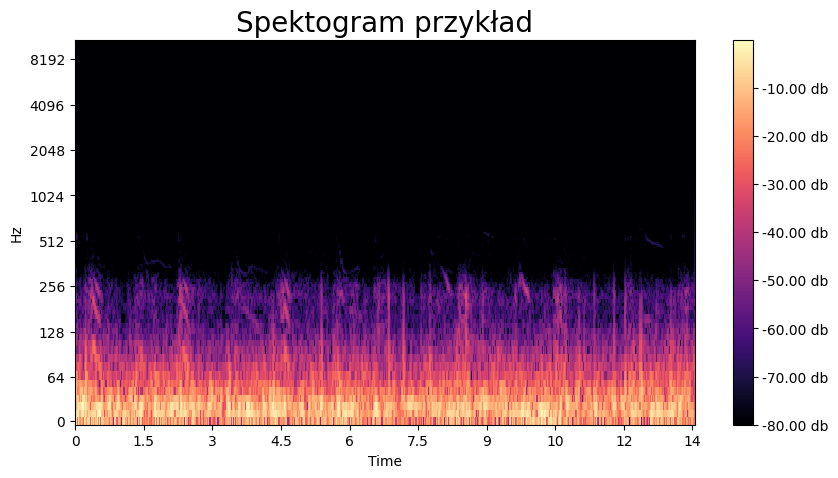

In [17]:
# Spektogram z dźwięku
fig, ax = plt.subplots(figsize=(10, 5))
img = librosa.display.specshow(S_db,
                              x_axis='time',
                              y_axis='log',
                              ax=ax)
ax.set_title('Spektogram przykład', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f db')
plt.show()

In [18]:
# Tworzenie spektogramu mel
mel_spec = librosa.feature.melspectrogram(y=wave,
                                   sr=sr,
                                   n_mels=128 * 2)
S_db_mel = librosa.amplitude_to_db(mel_spec, ref=np.max)

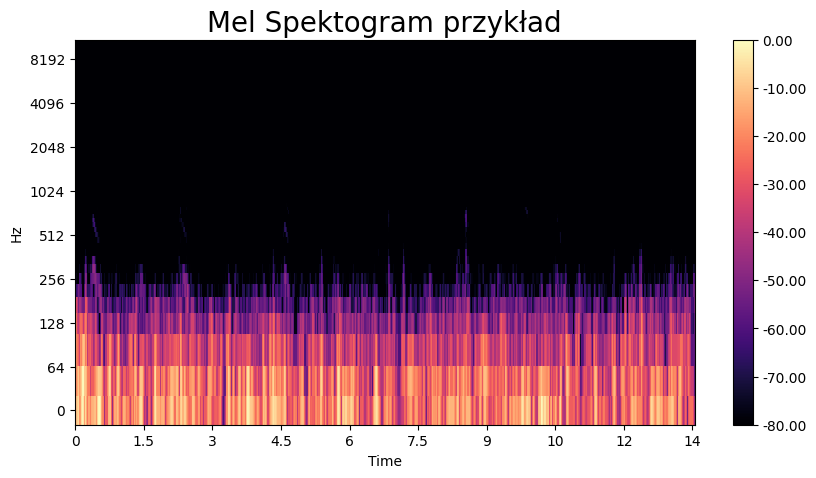

In [19]:
fig, ax = plt.subplots(figsize=(10, 5))
# Spektogram mel
img = librosa.display.specshow(S_db_mel,
                              x_axis='time',
                              y_axis='log',
                              ax=ax)
ax.set_title('Mel Spektogram przykład', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

## Powiększanie zbioru danych

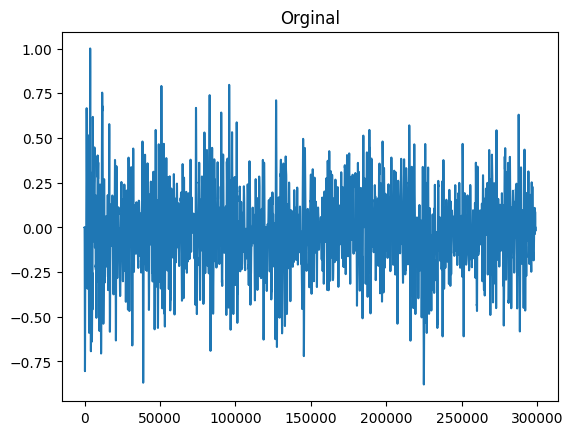

In [47]:
plt.plot(wave)
plt.title("Orginal")
plt.show()

In [48]:
ipd.Audio(wave,rate = 24000)

In [49]:
# Dodanie szumu do dźwięku
def add_white_noise(signal, noise_factor = 0.01):
    noise = np.random.normal(0, signal.std(), signal.size)
    augmented_signal = signal + noise * noise_factor
    return np.array(augmented_signal)

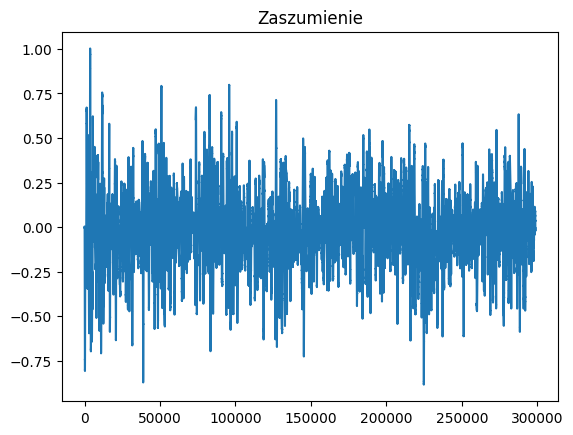

In [52]:
check = add_white_noise(wave.copy(),0.01)
plt.plot(check)
plt.title("Zaszumienie")
plt.show()

In [53]:
ipd.Audio(check,rate = 24000)

In [58]:
# Rozciągnięcie
def time_stretch(signal, stretch_rate = 0.8):
    return np.array(librosa.effects.time_stretch(y = signal, rate = stretch_rate))

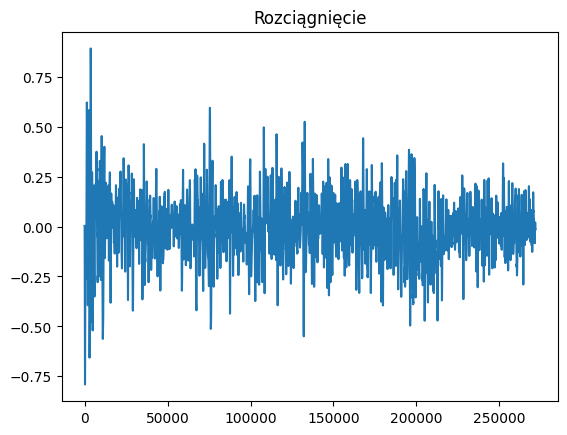

In [110]:
check = time_stretch(wave.copy(), 1.1)
plt.plot(check)
plt.title("Rozciągnięcie")
plt.show()

In [62]:
ipd.Audio(check,rate = 24000)

In [111]:
# Przesunięcie wysokości przebiegu
def pitch_scale(signal, sr, num_semitones = 12):
    return np.array(librosa.effects.pitch_shift(y = signal, sr = sr, n_steps = num_semitones))

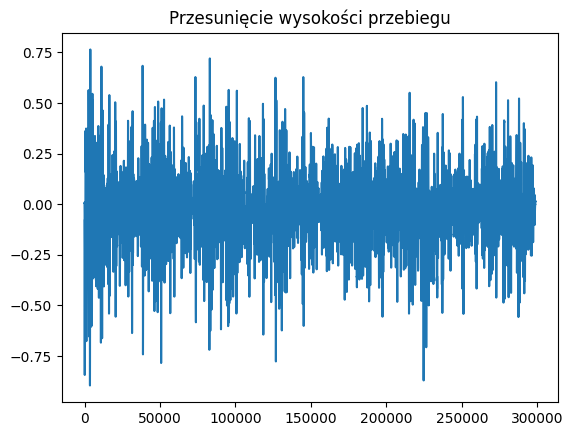

In [71]:
check = pitch_scale(signal = wave.copy(), sr = sr, num_semitones = 12)
plt.plot(check)
plt.title("Przesunięcie wysokości przebiegu")
plt.show()

In [72]:
ipd.Audio(check,rate = 24000)

In [127]:
import noisereduce as nr
# Usuwanie szumu
def reduce_noise(signal, strength = 1):
    return np.array(nr.reduce_noise(y = signal, sr = 24000 , n_std_thresh_stationary = strength, stationary=True))

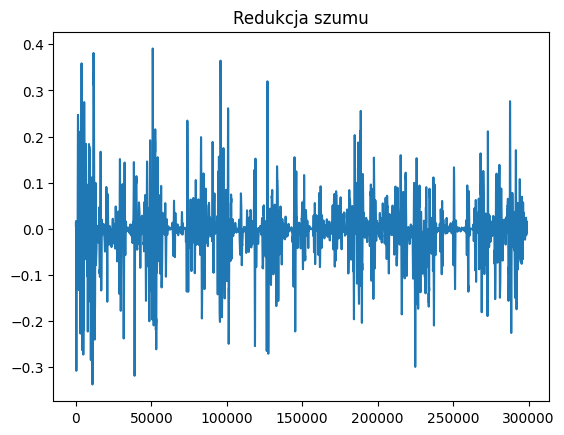

In [126]:
check = reduce_noise(signal = wave.copy(), strength= 0.5)
plt.plot(check)
plt.title("Redukcja szumu")
plt.show()

In [128]:
ipd.Audio(data = check, rate = 24000)

In [129]:
# Losowa zmiana wartości
def random_gain(signal,min_gain_factor = 2, max_gain_factor = 4):
    gain_factor = np.random.uniform(min_gain_factor,max_gain_factor)
    return np.array(signal * gain_factor)

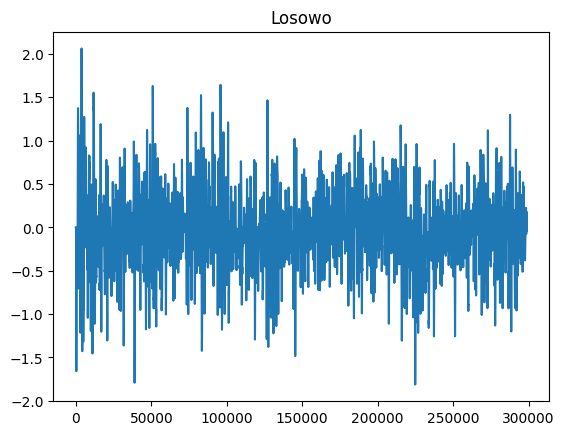

In [130]:
check = random_gain(signal = wave.copy(), min_gain_factor = 2, max_gain_factor = 4)
plt.plot(check)
plt.title("Losowo")
plt.show()

In [119]:
ipd.Audio(data = check, rate = 24000)

## Tworzenie dataset'u

In [102]:
SAMPLE_RATE = 24000
CHUNK_LENGTH = 3 # w sekundach

In [121]:
# Nanieś wszystkie możliwe przetwarzania na wybraną sekcję
def preprocess_augmentation(chunks):
    augmented_chunks = []
    for chunk in chunks:
        aug_ch = add_white_noise(signal = chunk.copy(), noise_factor = 0.1)
        augmented_chunks.append(aug_ch)

        aug_ch = time_stretch(chunk.copy(), stretch_rate = 0.8)
        augmented_chunks.append(aug_ch)

        aug_ch = time_stretch(chunk.copy(), stretch_rate = 1.05)
        augmented_chunks.append(aug_ch)

        aug_ch = pitch_scale(signal = chunk.copy(), sr = 24000, num_semitones = 12)
        augmented_chunks.append(aug_ch)

        aug_ch = reduce_noise(signal = chunk.copy(), strength = 0.5)
        augmented_chunks.append(aug_ch)

        aug_ch = random_gain(signal = chunk.copy(), min_gain_factor = 2, max_gain_factor = 4)
        augmented_chunks.append(aug_ch)

    return augmented_chunks

In [99]:
#Zapis spektogramu
def save_spectogram(spectogram,class_name,file, index = 0):
    file_name = file[:-5]
    #print(file_name)
    
    saved_path = os.path.join(f'./data/spectograms/{class_name}/{file_name}_{index}.png')
    print(saved_path)

    image = Image.fromarray(spectogram * 255).convert("L")
    image.save(saved_path)

In [98]:
def get_mel_spectograms(filepath,sample_rate=22000,image_shape=(224,224), use_augmentation = False):
    #Wczytanie pliku audio
    wave, rate = librosa.load(path = filepath, sr = sample_rate)

    #Podział dźwięku na odcinki
    signal_splits = []

    for i in range(0,len(wave),int(CHUNK_LENGTH * SAMPLE_RATE)):
        chunk = wave[i:i + int(CHUNK_LENGTH * SAMPLE_RATE)]

        if len(chunk) < int(CHUNK_LENGTH * SAMPLE_RATE):
            break
        
        signal_splits.append(np.array(chunk))

    #Uzywanie augmentation
    if use_augmentation == True:
        augmented_chunks = preprocess_augmentation(signal_splits)
        signal_splits.extend(augmented_chunks)

    #Tworzenie mel spektogramu dla kazdego z odcinka
    ready_mel_spectograms = []

    for chunk in signal_splits:

        mel_spectogram = librosa.feature.melspectrogram(y = chunk,
                                                        sr = rate,
                                                        n_fft = 1024,
                                                        hop_length = 512,
                                                        n_mels = image_shape[0] * 1,
                                                        fmin = 100,
                                                        fmax = 24000)
        
        mel_spectogram = librosa.amplitude_to_db(mel_spectogram, ref = np.max)

        #Normalizacja
        mel_spectogram -= mel_spectogram.min()
        mel_spectogram /= mel_spectogram.max()

        #Dodanie melspektogramu do listy
        ready_mel_spectograms.append(np.array(mel_spectogram))

    return ready_mel_spectograms

In [108]:
def prepare_spectograms():

    class_names = os.listdir('./data/audio')
    print(f"Nazwy klas: {class_names}")

    for class_name in class_names:
        files_disease = os.listdir(f'./data/audio/{class_name}')

        for file in files_disease:
            print(f"{class_name} - > {file}")

            mel_spectograms = get_mel_spectograms(f'./data/audio/{class_name}/{file}', sample_rate = SAMPLE_RATE, use_augmentation = True)

            #Zapis spektogramów
            for idx, spec in enumerate(mel_spectograms):
                save_spectogram(spectogram = spec, class_name = class_name, file = file,index = idx)            
            
    print("SPEKTOGRAMY ZOSTAŁY PRZYGOTOWANE...")

e:\Anaconda\envs\detect\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


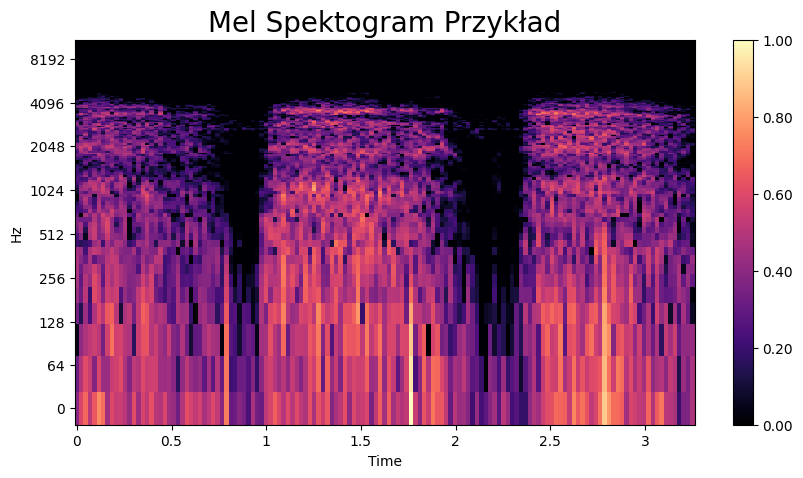

In [106]:
test = get_mel_spectograms('./data/audio/Bronchiectasis/111_1b2_Tc_sc_Meditron.wav')

fig, ax = plt.subplots(figsize=(10, 5))
# Spektogram mel
img = librosa.display.specshow(test[0],
                              x_axis='time',
                              y_axis='log',
                              ax=ax)
ax.set_title('Mel Spektogram Przykład', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

## Przygotowanie spektogramów z plików audio dla zbioru ICBHI

In [109]:
prepare_spectograms()

Nazwy klas: ['Asthma', 'Bronchiectasis', 'Bronchiolitis', 'COPD', 'Covid-19', 'Healthy', 'Heart_Failure', 'LRTI', 'Pneumonia', 'Symptomatic', 'URTI']
Asthma - > 103_2b2_Ar_mc_LittC2SE.wav


NameError: name 'random_gain' is not defined

 # Przygotowanie danych ze zbioru KAUH

In [ ]:
kauh_dataset = pd.read_excel(f'{KAUH_DATA_PATH}/Data annotation.xlsx',usecols=range(5))
kauh_dataset.info()

In [ ]:
unique_diseases_kauh = kauh_dataset['Diagnosis'].unique()
print(unique_diseases_kauh)

In [ ]:
diseases_kauh_count = kauh_dataset.groupby('Diagnosis').count()
print(diseases_kauh_count['Age'].sort_values(ascending=False))

## Segregowanie danych

In [ ]:
kauh_disease_dir = {'Asthma': ['Asthma','Asthma and lung fibrosis','asthma'],
                    'Bronchiectasis' : ['BRON'],
                    'COPD': ['COPD','copd'],
                    'Heart_Failure': ['heart failure','Heart Failure','Heart Failure + COPD'],
                    'Healthy': ['N'],
                    'Pneumonia' : ['pneumonia']}

kauh_disease_file_list = {'Asthma': [],
                        'Bronchiectasis' : [],
                        'COPD': [],
                        'Heart_Failure': [],
                        'Healthy': [],
                        'Pneumonia' : []}

In [ ]:
import re

kauh_files = os.listdir(f'{KAUH_DATA_PATH}/Audio Files/')

#print(kauh_files)

for key_category, diseases_list in kauh_disease_dir.items():
    print(f'Category -> {key_category}')

    for disease in diseases_list:
        print(f'\t -> : {disease}')

        #Segregowanie plików audio ze względu na nazwy
        find_names = []
        
        for file in kauh_files:
            is_find = re.search(f"_{disease},",file)

            if is_find != None:
                print(f' --> {file}')
                kauh_disease_file_list[key_category].append(file)

#for key_category, diseases_list in kauh_disease_file_list.items():
#   print(diseases_list)

## Tworzenie dataset'u

In [ ]:
if not os.path.exists(f"./data/audio"):
        os.mkdir(f"./data/audio")

if not os.path.exists(f"./data/spectograms"):
    os.mkdir(f"./data/spectograms")
    
# Tworzenie nowych podfolderów
for diseas in kauh_disease_dir.keys():

    if not os.path.exists(f"./data/audio/{diseas}"):
        print(f"TWORZENIE PODKATALOGU DLA AUDIO CHOROBY : {diseas}")
        os.mkdir(f"./data/audio/{diseas}")
    
    if not os.path.exists(f"./data/spectograms/{diseas}"):
        print(f"TWORZENIE PODKATALOGU DLA SPEKTOGRAMÓW CHOROBY : {diseas}")
        os.mkdir(f"./data/spectograms/{diseas}")

In [ ]:
# Kopiowanie plików do odpowiednich folderów

for key_category, diseases__file_list in kauh_disease_file_list.items():

    for file in diseases__file_list:

        print(f'COPY: {KAUH_DATA_PATH}/Audio Files/{file} -> ./data/audio/{key_category}')
        shutil.copy(src = f'{KAUH_DATA_PATH}/Audio Files/{file}', dst = f'./data/audio/{key_category}')

### Tworzenie spektogramów

In [ ]:
prepare_spectograms()

# Przygotowanie danych dla zbioru Covid-19

In [ ]:
covid_19_dataset = pd.read_csv(f'{COVID_19_DATA_PATH}/metadata_compiled.csv')
covid_19_dataset.info()

In [ ]:
# Pobranie kolumn z indetyfikatorem pliku oraz statusem
covid_19_dataset_prep = covid_19_dataset[['uuid','status']]

In [ ]:
# Usuwanie pustych krotek
print("Wyświetlenie ilość poszczególnych przypadków:")
print(covid_19_dataset_prep.groupby('status').count())
print("\nIlość danych w których pole status jest puste:")
print(covid_19_dataset_prep.isnull().sum())

covid_19_dataset_prep = covid_19_dataset_prep.dropna()

print("\nPo usunięciu pustych pól:")
print(covid_19_dataset_prep.isnull().sum())

In [ ]:
# Wyłuskanie unikalnych nazw statusu
covid_19_labels_diseases = covid_19_dataset_prep['status'].unique()

print(covid_19_labels_diseases)

In [ ]:
if not os.path.exists(f"./data/audio"):
        os.mkdir(f"./data/audio")

if not os.path.exists(f"./data/spectograms"):
    os.mkdir(f"./data/spectograms")

# Tworzenie podfolderów
for diseas in covid_19_labels_diseases:
    diseas = diseas.capitalize()
    if not os.path.exists(f"./data/audio/{diseas}"):
        print(f"TWORZENIE PODKATALOGU DLA AUDIO CHOROBY : {diseas}")
        os.mkdir(f"./data/audio/{diseas}")

    if not os.path.exists(f"./data/spectograms/{diseas}"):
        print(f"TWORZENIE PODKATALOGU DLA SPEKTOGRAM CHOROBY : {diseas}")
        os.mkdir(f"./data/spectograms/{diseas}")

In [ ]:
# Zmiany nazw wartości
covid_19_dataset_prep.loc[covid_19_dataset_prep["status"] == "healthy","status"] = "Healthy"
covid_19_dataset_prep.loc[covid_19_dataset_prep["status"] == "symptomatic","status"] = "Symptomatic"

In [ ]:
# Ewentualne przycinanie zbioru COVID-19
LICZBA_PLIKOW = 100

covid_19_ds_copy = covid_19_dataset_prep.copy(deep = True)

# Ograniczenie liczby plików branych pod uwagę
covid_19_Healthy = covid_19_ds_copy[covid_19_ds_copy["status"] == "Healthy"].sample(LICZBA_PLIKOW)
covid_19_Symptomatic = covid_19_ds_copy[covid_19_ds_copy["status"] == "Symptomatic"].sample(LICZBA_PLIKOW)
covid_19_Covid_19 = covid_19_ds_copy[covid_19_ds_copy["status"] == "COVID-19"].sample(LICZBA_PLIKOW)
#print(covid_19_Healthy)
#print(len(covid_19_Healthy))

# Łączenie przyciętych podzbiorów w jeden
covid_19_dataset_prep = pd.concat([covid_19_Healthy, covid_19_Symptomatic, covid_19_Covid_19])
print(f"Wielkość przyciętego zbioru: {len(covid_19_dataset_prep)}")

In [ ]:
covid_19_pre_ready = covid_19_dataset_prep

# Kopiowanie plików
for index, row in covid_19_pre_ready.iterrows():
    print(row['uuid'], row['status'])

    try:
        file_name = f"{row['uuid']}.webm"
        
        print(f"COPY : {COVID_19_DATA_PATH}/{file_name} -> ./data/audio/{row['status']}/{file_name}")
        shutil.copy(src = f'{COVID_19_DATA_PATH}/{file_name}', dst = f'./data/audio/{row["status"]}/')
    except FileNotFoundError:

        try:
            file_name = f"{row['uuid']}.ogg"
        
            print(f"COPY : {COVID_19_DATA_PATH}/{file_name} -> ./data/audio/{row['status']}/{file_name}")
            shutil.copy(src = f'{COVID_19_DATA_PATH}/{file_name}', dst = f'./data/audio/{row["status"]}/')
        except Exception:
            pass

### Tworzenie spektogramów

In [ ]:
prepare_spectograms()

## Sprawdzenie liczności zbioru

In [ ]:
# Liczność każdej z przypadłości

diseases_total = os.listdir('./data/spectograms')
disease_files_len = []

#print(diseases_total)

for diseases in diseases_total:
    print(diseases,end=" -> ")
    selected_disese = os.listdir(f"./data/spectograms/{diseases}")
    print(len(selected_disese))
    disease_files_len.append([diseases,len(selected_disese)])

diseases_df = pd.DataFrame(data = disease_files_len, columns = ['Choroba','Ilosc'])
diseases_df.head(15)

In [ ]:
plt.figure(figsize=(10,8))
plt.pie(diseases_df['Ilosc'],labels=diseases_df['Choroba'],autopct='%1.1f%%')
plt.title("Ilość % chorób w zbiorze końcowym")
plt.show()